In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

### 데이터셋 준비

In [3]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [4]:
# 수익률
rets = data.pct_change().fillna(0)

In [5]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 동일 비중 포트폴리오

<Axes: xlabel='Date'>

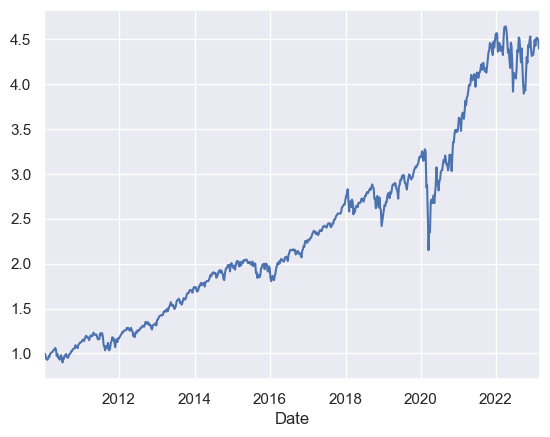

In [6]:
# 동일 비중 포트폴리오 수익률
port_rets = rets.mean(axis=1)

# 백테스팅 결과
(1 + port_rets).cumprod().plot()

### 변동성 타게팅 모델

<Axes: xlabel='Date'>

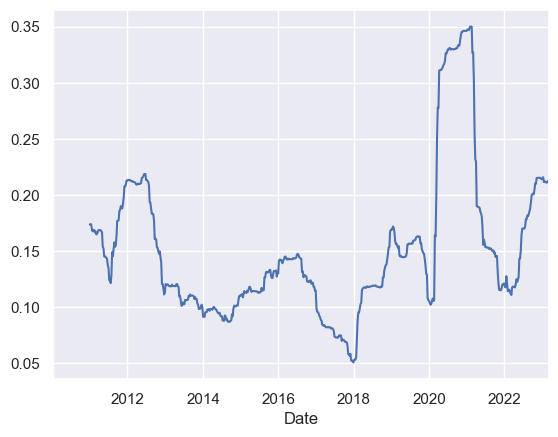

In [7]:
# 1년 롤링 변동성 계산
rolling_vol = port_rets.rolling(52).std() * np.sqrt(52)
rolling_vol.plot()

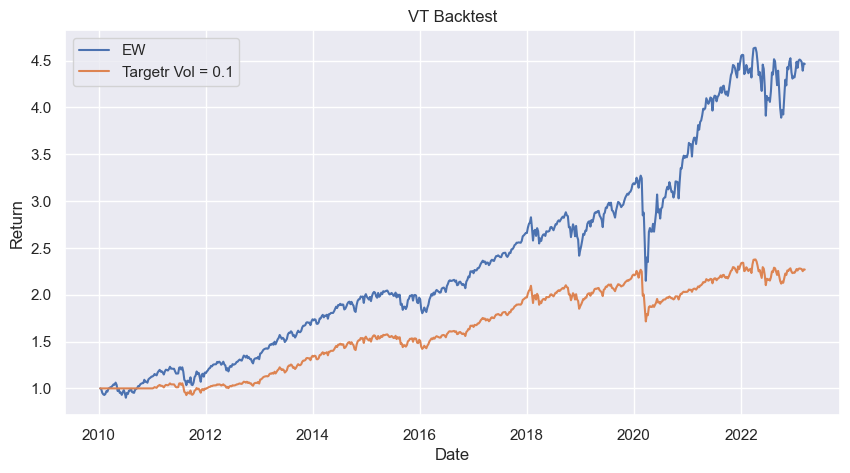

In [9]:
# 변동성 타게팅을 사용해 투자 가중치 산출
# 타겟 변동성 = 10%
target_vol = 0.1
vt_weights = (target_vol / rolling_vol).fillna(0)

# 레버리지 사용 불가
vt_weights[vt_weights > 1] = 1

# 볼타겟 백테스팅 수익률
tvol_rets = (port_rets * vt_weights.shift()).fillna(0)
tvol_cum_rets = (1 + tvol_rets).cumprod()

# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod(), label='EW')
plt.plot(tvol_cum_rets, label=f'Targetr Vol = {target_vol}')
plt.title('VT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

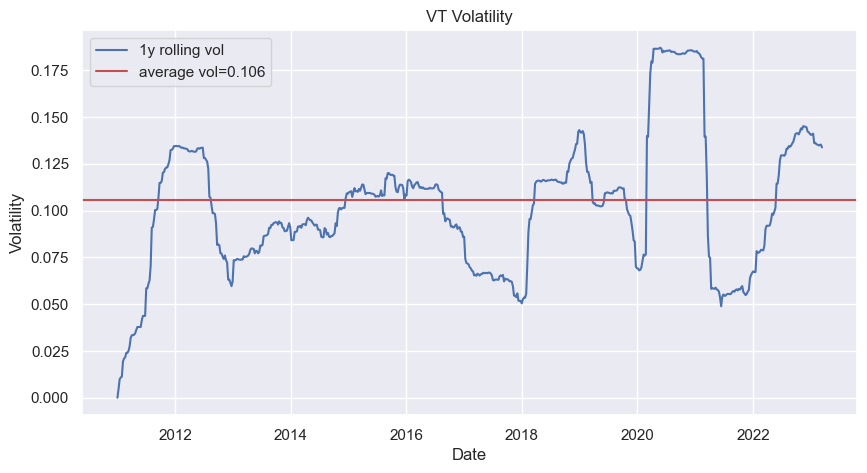

In [11]:
# 변동성 타게팅 포트폴리오의 시계열 변동성 시각화
plt.figure(figsize=(10, 5))
plt.plot((tvol_rets.rolling(52).std() * np.sqrt(52)).dropna(), label='1y rolling vol')

# 평균 변동성은 값 한개이므로 수평선으로 표시
plt.axhline((tvol_rets.std() * np.sqrt(52)).mean(), color='r', label=f'average vol={np.round((tvol_rets.std() * np.sqrt(52)).mean(), 3)}')
plt.title('VT Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [12]:
# 현금 보유 비중
1 - vt_weights

Date
2010-01-10    1.000000
2010-01-17    1.000000
2010-01-24    1.000000
2010-01-31    1.000000
2010-02-07    1.000000
                ...   
2023-02-12    0.526808
2023-02-19    0.526031
2023-02-26    0.528237
2023-03-05    0.529700
2023-03-12    0.526933
Freq: W-SUN, Length: 688, dtype: float64

In [13]:
# 투자 비중 데이터프레임 생성
vt_weights_df = pd.concat([vt_weights, 1-vt_weights], axis=1, join='inner')
vt_weights_df.columns = ['portfolio', 'cash']
vt_weights_df

,portfolio,cash
Date,,
2010-01-10,0.000000,1.000000
2010-01-17,0.000000,1.000000
2010-01-24,0.000000,1.000000
2010-01-31,0.000000,1.000000
2010-02-07,0.000000,1.000000
...,...,...
2023-02-12,0.473192,0.526808
2023-02-19,0.473969,0.526031
2023-02-26,0.471763,0.528237


Text(0, 0.5, 'Weights')

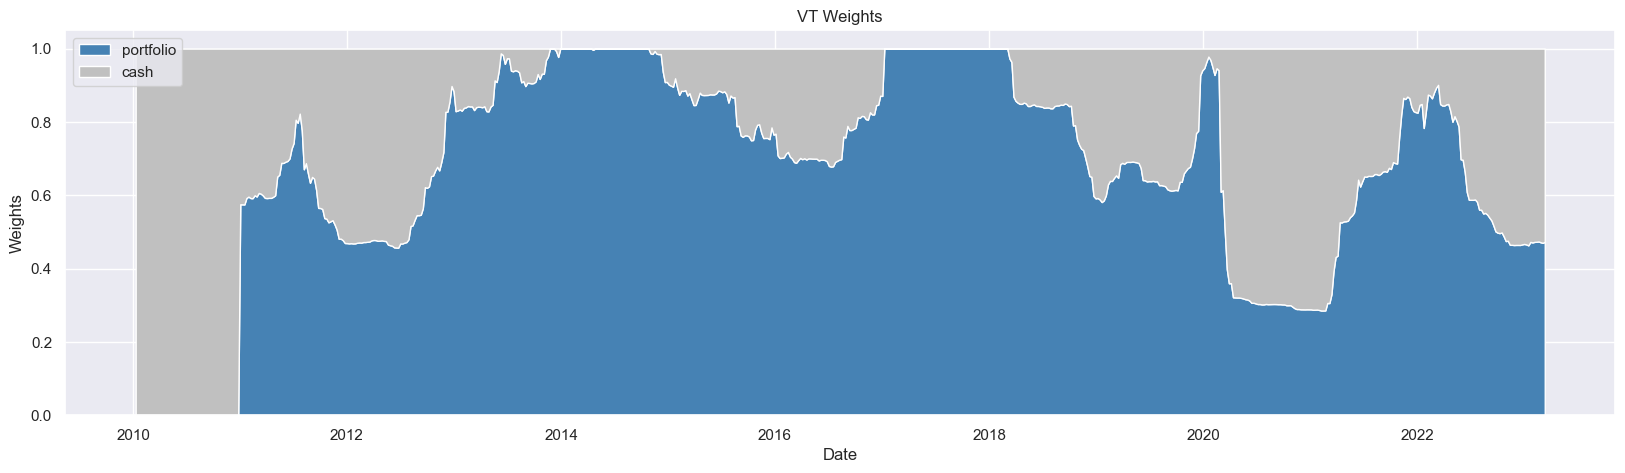

In [14]:
# 시계열 플랏 시각화
plt.figure(figsize=(20, 5))
plt.stackplot(vt_weights_df.index, vt_weights_df.T, labels=vt_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('VT Weights')
plt.xlabel('Date')
plt.ylabel('Weights')